In [3]:
# !pip install skforecast

In [34]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

## Forecasting autorregresivo recursivo

In [5]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

In [6]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()

,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


In [7]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [8]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


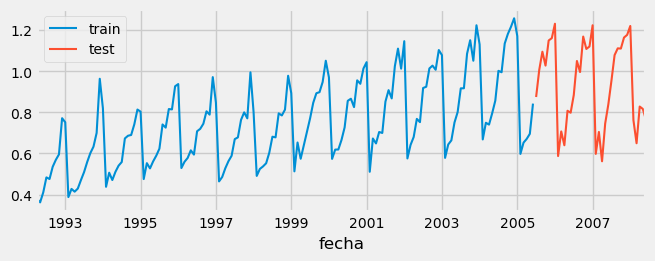

In [9]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

Se crea y entrena un modelo `ForecasterAutoreg` a partir de un regresor `RandomForestRegressor` y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [10]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-06-28 19:31:51 
Last fit date: 2023-06-28 19:31:51 
Skforecast version: 0.8.1 
Python version: 3.7.16 
Forecaster id: None

In [11]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

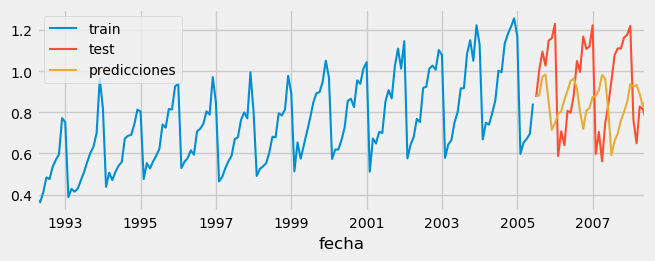

In [13]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [14]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.07326833976120374


**Model tunning**

In [15]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.012836389345193383



In [16]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.012836,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.012858,3,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.013248,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.013364,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.013435,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.014028,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.036982,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.037345,3,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.037574,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.040542,10,500


In [17]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train['y'])

In [18]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

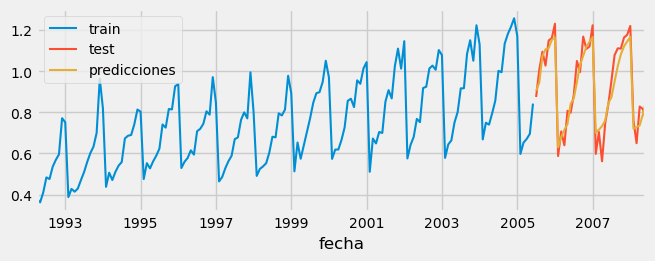

In [19]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [20]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.004392699665157793


**Backtesting**

In [21]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

Error de backtest: 0.010578977232387663


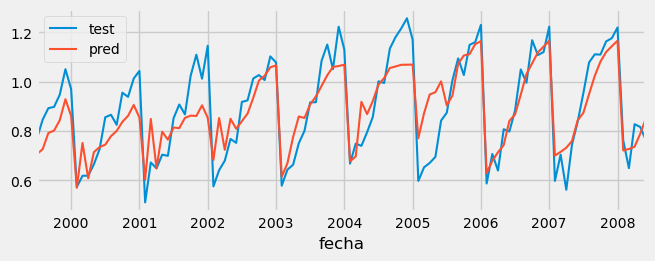

In [22]:
fig, ax = plt.subplots(figsize=(7, 2.5))
datos.loc[predicciones_backtest.index, 'y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

**Importancia de los predictores**

In [23]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importances()
impotancia

,feature,importance
0,lag_1,0.009412
1,lag_2,0.087268
2,lag_3,0.012754
3,lag_4,0.001446
4,lag_5,0.000401
5,lag_6,0.001386
6,lag_7,0.001273
7,lag_8,0.006926
8,lag_9,0.005839
9,lag_10,0.013076


## Forecasting autorregresivo recursivo con variables exógenas

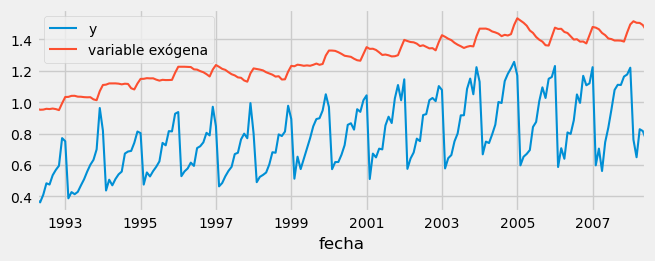

In [24]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

fig, ax = plt.subplots(figsize=(7, 2.5))
datos['y'].plot(ax=ax, label='y')
datos['exog_1'].plot(ax=ax, label='variable exógena')
ax.legend();

In [25]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [26]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=datos_train['y'], exog=datos_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-06-28 19:42:19 
Last fit date: 2023-06-28 19:42:19 
Skforecast version: 0.8.1 
Python 

In [27]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

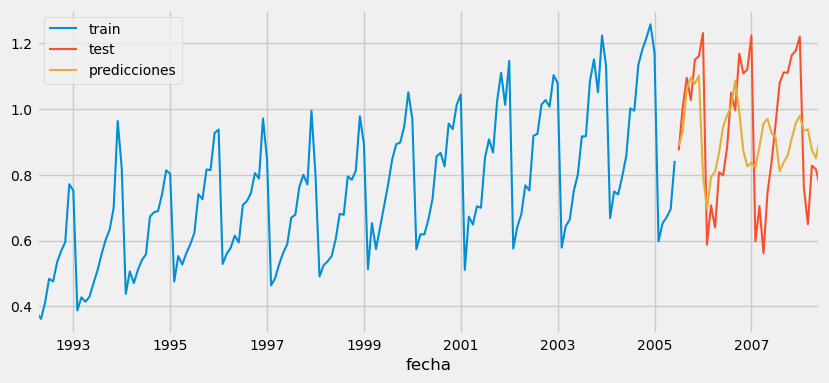

In [28]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [29]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.03989087922533575


In [30]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        exog               = datos_train['exog_1'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                    )

Number of models compared: 27.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 0.011894059611047655



In [31]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

,lags,params,mean_squared_error,max_depth,n_estimators
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 50}",0.011894,10,50
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 100}",0.012698,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 50}",0.012836,3,50
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.012845,3,500
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 500}",0.012945,10,500


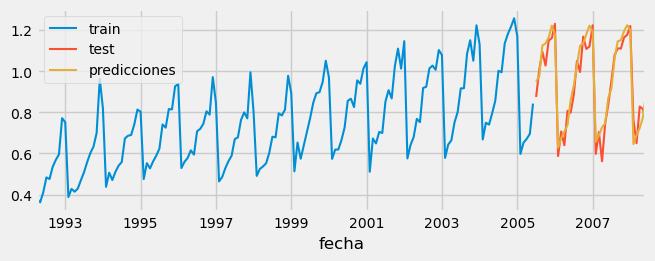

In [32]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [33]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.0044949967759907675
